In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import random
import pickle
from sklearn.metrics import (classification_report, confusion_matrix,accuracy_score, roc_curve, auc)
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import seaborn as sns


Imports done. Seeds set for reproducibility.


In [15]:

seed = 42
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

print("Imports done. Seeds set for reproducibility.")

Imports done. Seeds set for reproducibility.


# ---------------------------------------------------------
# 2. Data Preparation and Augmentation
# ---------------------------------------------------------

In [7]:

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),     
    transforms.RandomHorizontalFlip(),     
    transforms.ToTensor(),              
    transforms.Normalize((0.4914, 0.4822, 0.4465),  
                         (0.2023, 0.1994, 0.2010))
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

# Load the CIFAR-10 training and test datasets
train_dataset_full = torchvision.datasets.CIFAR10(
    root='./data',    
    train=True,    
    download=True,           
    transform=transform_train 
)
test_dataset = torchvision.datasets.CIFAR10(
    root='./data',
    train=False,             
    download=True,
    transform=transform_test  
)
# Creating a Train/Validation Split (90/10 split)
val_size = int(0.1 * len(train_dataset_full)) 
train_size = len(train_dataset_full) - val_size

# Random split for train/validation
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset_full, [train_size, val_size])

# Create DataLoaders for train,validation, test
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)
print(f"Training samples: {len(train_dataset)}, Validation samples: {len(val_dataset)}, Test samples: {len(test_dataset)}")


Data loaded and train/validation split created.
Training samples: 45000, Validation samples: 5000, Test samples: 10000


# ---------------------------------------------------------
# 3. Simple CNN Model Definition
# ---------------------------------------------------------

In [8]:

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv_layer = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.25),
            
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.25)
        )
        # Fully connected layers
        self.fc_layer = nn.Sequential(
            nn.Linear(64 * 8 * 8, 512),  #64 channels 8x8 after two poolings
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 10)  #10 classes for CIFAR10
        )
    def forward(self, x):
        x = self.conv_layer(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layer(x)
        return x


Model class 'SimpleCNN' defined.


# ---------------------------------------------------------
# 4. Training and Evaluation Functions
# ---------------------------------------------------------

In [9]:


def train_epoch(model, device, dataloader, optimizer, criterion):
    model.train()           
    running_loss = 0.0

    for data, target in dataloader:
        data, target = data.to(device), target.to(device)  
        optimizer.zero_grad()             
        output = model(data)               
        loss = criterion(output, target)   
        loss.backward()                    
        optimizer.step()                   
        running_loss += loss.item() * data.size(0)

    epoch_loss = running_loss / len(dataloader.dataset)
    return epoch_loss

def evaluate(model, device, dataloader, criterion):
    model.eval()          
    running_loss = 0.0
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for data, target in dataloader:
            data, target = data.to(device), target.to(device)
            output = model(data)                           
            loss = criterion(output, target)
            running_loss += loss.item() * data.size(0)
            preds = output.softmax(dim=1).cpu().numpy()  
            all_preds.append(preds)
            all_targets.append(target.cpu().numpy())       
    
    all_preds = np.concatenate(all_preds, axis=0)          
    all_targets = np.concatenate(all_targets, axis=0)      
    epoch_loss = running_loss / len(dataloader.dataset)
    predicted_classes = np.argmax(all_preds, axis=1)
    accuracy = accuracy_score(all_targets, predicted_classes)
    return epoch_loss, accuracy, all_preds, all_targets


Training and evaluation functions defined.


# ---------------------------------------------------------
# 5. Training Loop with Early Stopping
# ---------------------------------------------------------

In [10]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device used for training/evaluation: {device}")

model = SimpleCNN().to(device)              
criterion = nn.CrossEntropyLoss()            
optimizer = optim.Adam(model.parameters(), lr=0.001)  
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', patience=3, factor=0.5, verbose=True
)
num_epochs = 20
best_val_loss = float('inf')
patience = 5       
trigger_times = 0
train_losses, val_losses = [], []

for epoch in range(num_epochs):
    train_loss = train_epoch(model, device, train_loader, optimizer, criterion)
    
    # Evaluate on validation set
    val_loss, val_accuracy, _, _ = evaluate(model, device, val_loader, criterion)
    
    # Step the scheduler with the validation loss
    scheduler.step(val_loss)
    
    # Record losses for visualization
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1} | "
          f"Train Loss: {train_loss:.4f} | "
          f"Val Loss: {val_loss:.4f} | "
          f"Val Acc: {val_accuracy:.4f}")
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model.pth') 
        trigger_times = 0
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print("Early stopping triggered!")
            break

print("Training loop completed.")


Device used for training/evaluation: cpu


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1 | Train Loss: 1.7908 | Val Loss: 1.5189 | Val Acc: 0.4372
Epoch 2 | Train Loss: 1.5635 | Val Loss: 1.3748 | Val Acc: 0.5094
Epoch 3 | Train Loss: 1.4857 | Val Loss: 1.2927 | Val Acc: 0.5388
Epoch 4 | Train Loss: 1.4139 | Val Loss: 1.1978 | Val Acc: 0.5702
Epoch 5 | Train Loss: 1.3702 | Val Loss: 1.2084 | Val Acc: 0.5640
Epoch 6 | Train Loss: 1.3349 | Val Loss: 1.1633 | Val Acc: 0.5776
Epoch 7 | Train Loss: 1.3022 | Val Loss: 1.1006 | Val Acc: 0.6134
Epoch 8 | Train Loss: 1.2782 | Val Loss: 1.0988 | Val Acc: 0.6130
Epoch 9 | Train Loss: 1.2587 | Val Loss: 1.0622 | Val Acc: 0.6272
Epoch 10 | Train Loss: 1.2409 | Val Loss: 1.0483 | Val Acc: 0.6332
Epoch 11 | Train Loss: 1.2183 | Val Loss: 0.9988 | Val Acc: 0.6546
Epoch 12 | Train Loss: 1.2032 | Val Loss: 0.9981 | Val Acc: 0.6500
Epoch 13 | Train Loss: 1.1915 | Val Loss: 1.0091 | Val Acc: 0.6470
Epoch 14 | Train Loss: 1.1805 | Val Loss: 0.9910 | Val Acc: 0.6514
Epoch 15 | Train Loss: 1.1647 | Val Loss: 0.9682 | Val Acc: 0.6624
Epoc

# ---------------------------------------------------------
# 6. Final Evaluation on Test Set
# ---------------------------------------------------------

In [11]:

model.load_state_dict(torch.load('best_model.pth'))

# Evaluate on the test set
test_loss, test_accuracy, preds, targets = evaluate(model, device, test_loader, criterion)

print(f"\nFinal Test Evaluation:")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")



Final Test Evaluation:
Test Loss: 0.8303
Test Accuracy: 0.7187


# ---------------------------------------------------------
# 7. Metrics and Visualization
# ---------------------------------------------------------


Classification Report:
              precision    recall  f1-score   support

           0     0.8061    0.6820    0.7389      1000
           1     0.8890    0.8010    0.8427      1000
           2     0.5985    0.5590    0.5781      1000
           3     0.5520    0.5040    0.5269      1000
           4     0.6673    0.6820    0.6746      1000
           5     0.5973    0.6540    0.6243      1000
           6     0.7281    0.8220    0.7722      1000
           7     0.7727    0.7750    0.7738      1000
           8     0.7645    0.8960    0.8250      1000
           9     0.8244    0.8120    0.8181      1000

    accuracy                         0.7187     10000
   macro avg     0.7200    0.7187    0.7175     10000
weighted avg     0.7200    0.7187    0.7175     10000



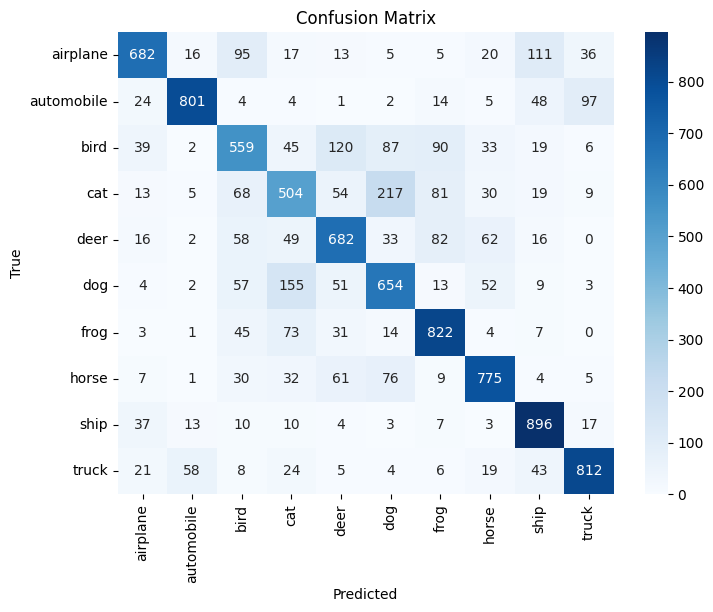

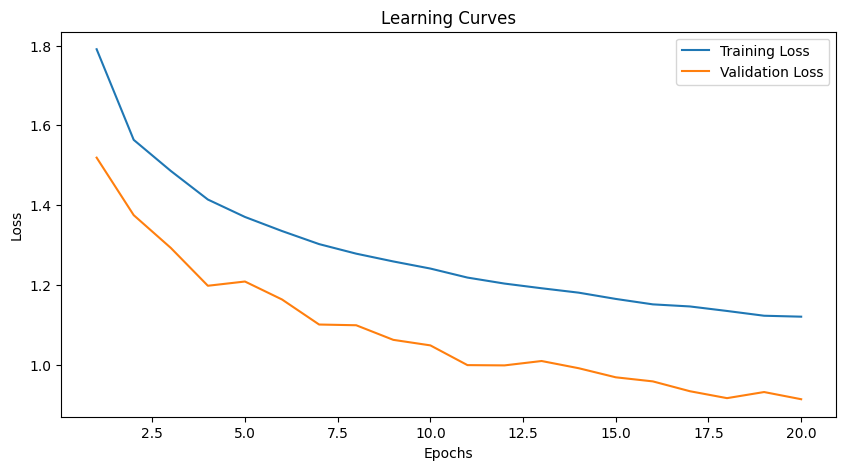

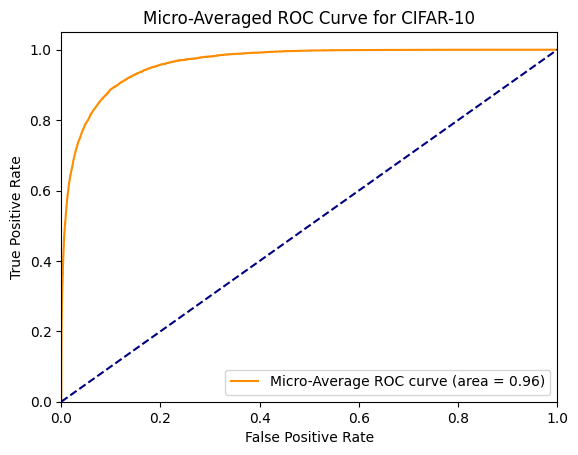


Visualization completed.


In [12]:

from sklearn.metrics import classification_report, confusion_matrix

# Classification Report
print("\nClassification Report:")
print(classification_report(targets, np.argmax(preds, axis=1), digits=4))

# Confusion Matrix
cm = confusion_matrix(targets, np.argmax(preds, axis=1))

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=train_dataset_full.classes, 
            yticklabels=train_dataset_full.classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Learning Curves (Training vs Validation Loss)
epochs_range = range(1, len(train_losses) + 1)
plt.figure(figsize=(10, 5))
plt.plot(epochs_range, train_losses, label='Training Loss')
plt.plot(epochs_range, val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Learning Curves')
plt.legend()
plt.show()

# ROC Curve (Micro-Averaged) for Multi-Class
# We need to binarize the targets for multi-class ROC calculation
num_classes = 10
binarized_targets = label_binarize(targets, classes=range(num_classes))
fpr, tpr, _ = roc_curve(binarized_targets.ravel(), preds.ravel())
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', 
         label=f'Micro-Average ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Micro-Averaged ROC Curve for CIFAR-10')
plt.legend(loc="lower right")
plt.show()



In [13]:
# Save and Load Model Outputs
with open("model_outputs.pkl", "wb") as f:
    pickle.dump((preds, targets), f)

def load_model_outputs(filepath="model_outputs.pkl"):
    with open(filepath, "rb") as f:
        return pickle.load(f)



Model predictions and targets have been saved to 'model_outputs.pkl'.
Use 'load_model_outputs()' to retrieve them later without re-running training.


# ---------------------------------------------------------
# Demonstration of K-Fold Cross-Validation
# ---------------------------------------------------------

In [14]:
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
fold_results = []

# We'll iterate over the splits and create a new model for each fold
for fold, (train_ids, val_ids) in enumerate(kfold.split(train_dataset_full)):
    print(f"\n--- Fold {fold+1} ---")
    sub_train_sampler = torch.utils.data.SubsetRandomSampler(train_ids)
    sub_val_sampler = torch.utils.data.SubsetRandomSampler(val_ids)

    train_loader_kf = torch.utils.data.DataLoader(train_dataset_full, batch_size=64, sampler=sub_train_sampler)
    val_loader_kf = torch.utils.data.DataLoader(train_dataset_full, batch_size=64, sampler=sub_val_sampler)

    # Re-initialize the model and optimizer for each fold
    model_kf = SimpleCNN().to(device)
    optimizer_kf = optim.Adam(model_kf.parameters(), lr=0.001)
    criterion_kf = nn.CrossEntropyLoss()
    best_fold_val_loss = float('inf')
    patience_kf = 3
    trigger_times_kf = 0
    max_epochs_kf = 10
    for epoch_kf in range(max_epochs_kf):
        
        # Train on this fold train split
        train_loss_kf = train_epoch(model_kf, device, train_loader_kf, optimizer_kf, criterion_kf)
        
        # Evaluate on this fold validation
        val_loss_kf, val_acc_kf, _, _ = evaluate(model_kf, device, val_loader_kf, criterion_kf)
        print(f"Fold {fold+1}, Epoch {epoch_kf+1}: Train Loss={train_loss_kf:.4f}, "
              f"Val Loss={val_loss_kf:.4f}, Val Acc={val_acc_kf:.4f}")

        # Simple early stopping for each fold
        if val_loss_kf < best_fold_val_loss:
            best_fold_val_loss = val_loss_kf
            torch.save(model_kf.state_dict(), f"best_model_fold_{fold+1}.pth")
            trigger_times_kf = 0
        else:
            trigger_times_kf += 1
            if trigger_times_kf >= patience_kf:
                print(f"Early stopping on fold {fold+1}")
                break

    model_kf.load_state_dict(torch.load(f"best_model_fold_{fold+1}.pth"))
    final_val_loss, final_val_acc, _, _ = evaluate(model_kf, device, val_loader_kf, criterion_kf)
    fold_results.append((final_val_loss, final_val_acc))

print("\nK-Fold results:", fold_results)
average_loss = np.mean([res[0] for res in fold_results])
average_acc = np.mean([res[1] for res in fold_results])
print(f"Average Loss across folds: {average_loss:.4f}")
print(f"Average Accuracy across folds: {average_acc:.4f}")



--- Fold 1 ---
Fold 1, Epoch 1: Train Loss=1.4249, Val Loss=0.2963, Val Acc=0.4509
Fold 1, Epoch 2: Train Loss=1.2412, Val Loss=0.2758, Val Acc=0.5052
Fold 1, Epoch 3: Train Loss=1.1765, Val Loss=0.2528, Val Acc=0.5370
Fold 1, Epoch 4: Train Loss=1.1207, Val Loss=0.2398, Val Acc=0.5684
Fold 1, Epoch 5: Train Loss=1.0749, Val Loss=0.2327, Val Acc=0.5810
Fold 1, Epoch 6: Train Loss=1.0522, Val Loss=0.2242, Val Acc=0.5967
Fold 1, Epoch 7: Train Loss=1.0235, Val Loss=0.2145, Val Acc=0.6153
Fold 1, Epoch 8: Train Loss=1.0019, Val Loss=0.2120, Val Acc=0.6250
Fold 1, Epoch 9: Train Loss=0.9805, Val Loss=0.2134, Val Acc=0.6219
Fold 1, Epoch 10: Train Loss=0.9617, Val Loss=0.2047, Val Acc=0.6404

--- Fold 2 ---
Fold 2, Epoch 1: Train Loss=1.4480, Val Loss=0.2978, Val Acc=0.4538
Fold 2, Epoch 2: Train Loss=1.2602, Val Loss=0.2772, Val Acc=0.5013
Fold 2, Epoch 3: Train Loss=1.1971, Val Loss=0.2614, Val Acc=0.5269
Fold 2, Epoch 4: Train Loss=1.1495, Val Loss=0.2463, Val Acc=0.5619
Fold 2, Epoch 5